# Introduction to Text Classification II

-----

In this notebook, we explore more advanced machine learning techniques with text data. First, we further explore the text classification we did in the previous lesson to see how can we improve. Next, we introduce the concept of n-grams, which are combinations of one or more tokens. For example, bigrams are combinations of two tokens, while trigrams are combinations of three tokens. Finally, we introdce sentiment analysis with a new text data set.

-----

## Table of Contents

[Explore Classifiers](#Explore-Classifiers)

[N-Grams](#N-Grams)

[N-Gram Classification](#N-Gram-Classification)

[Sentiment Analysis](#Sentiment-Analysis)

[Stemming](#Stemming)

-----

Before proceeding with the rest of this notebook, we first include the notebook setup code and we define our _home_ directory.

-----

In [1]:
# Set up Notebook
% matplotlib inline

# Standard imports
import numpy as np

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")


## Explore Classifiers

Let's explore the classifiers we used in the previous lesson. We can get top features(words, tokens) used by a classifier to predict each class. By examining the top words of each class, we get better understanding of the data set and the classifier. We hope this will help us improve the classification.

We first repeat the text classification on 20newsgroup dataset with MultinomialNB classifier. In the next code cell, we load the data and create DTM with `TfidfVectorizer`, then train the `MultinomialNB` model. 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups

# To learn more about these data, either browse the relevant 
# scikit learn documentation, or enter help(fetch_20newsgroups) in a Code cell

# Get training text set
train = fetch_20newsgroups(subset='train')
# Get testing text set
test = fetch_20newsgroups(subset='test')

# Create DTM
tf_cv = TfidfVectorizer(stop_words='english')
train_dtm_tf = tf_cv.fit_transform(train['data'])
test_dtm_tf = tf_cv.transform(test['data'])

nb = MultinomialNB()
nb = nb.fit(train_dtm_tf, train['target'])

predicted = nb.predict(test_dtm_tf)
scr = 100.0 * nb.score(test_dtm_tf, test['target'])
print(f'NB (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

NB (TF-IDF with Stop Words) prediction accuracy =  81.7%


-----

We can use the `coef_` attribute of a linear classifier(A linear classifier makes a classification decision based on the value of a linear combination of the characteristics or features. ie. MultinomialNB, LinearSVC, LogisticRegressoin) to identify the top features(words, tokens) for each category. `coef_` holds coefficients of all the features for each class. Since in text analysis, the features are tokens(words) in the whole training text set. Larger coefficient means more impact of the feature on predicting the class.

In the following code cell we use `coef_` to find out top 5 features(words, tokens) used to predicting each class. I'll explain the code a bit:

- first get all features from the vectorizer and convert the return value to a numpy array.
- iterate through all classes, in our case, the 20 newsgroups
- for each class, sort the classifiers' `coef_` attribute. For example, `nb.coef_[0]` is a list of coefficients for the first class, or _alt.atheism_ in our case. `np.argsort` is a numpy sort function that sorts a numpy array, but return a numpy array with indexes of the sorted array. For example, `np.argsort(np.array([2, 1, 3]))` returns a numpy array `[1, 0, 2]`. Because in the original array, item with index 1 is the samllest, item with index 0 is the second smallest and item with index 2 is the largest.
- Once we get index of sorted coefficient, keep the last 5 indexes as top_word_index since those indexes are corresponding to the top 5 largest coefficients.
- Use the top_word_index which is an array of indexes to find the top feature names(words)
- Reverse the list of words so that the most important one is at the first.

-----

In [3]:
# Display top 5 important words
all_words = np.array(tf_cv.get_feature_names())

for idx, target in enumerate(train['target_names']):
    top_word_index = np.argsort(nb.coef_[idx])[-5:]
    tn_lst = [word for word in all_words[top_word_index]]
    tn_lst.reverse()

    print(f'\n{target}:')
    print(tn_lst)


alt.atheism:
['keith', 'edu', 'god', 'caltech', 'atheists']

comp.graphics:
['graphics', 'edu', 'image', '3d', 'files']

comp.os.ms-windows.misc:
['windows', 'edu', 'file', 'dos', 'files']

comp.sys.ibm.pc.hardware:
['scsi', 'drive', 'ide', 'card', 'edu']

comp.sys.mac.hardware:
['mac', 'apple', 'edu', 'drive', 'quadra']

comp.windows.x:
['window', 'motif', 'mit', 'server', 'com']

misc.forsale:
['sale', 'edu', '00', 'offer', 'shipping']

rec.autos:
['car', 'com', 'cars', 'edu', 'engine']

rec.motorcycles:
['bike', 'com', 'dod', 'edu', 'ride']

rec.sport.baseball:
['edu', 'baseball', 'year', 'team', 'game']

rec.sport.hockey:
['hockey', 'team', 'game', 'ca', 'edu']

sci.crypt:
['key', 'clipper', 'encryption', 'chip', 'com']

sci.electronics:
['edu', 'com', 'use', 'lines', 'subject']

sci.med:
['pitt', 'edu', 'geb', 'banks', 'gordon']

sci.space:
['space', 'nasa', 'edu', 'henry', 'moon']

soc.religion.christian:
['god', 'jesus', 'christians', 'church', 'edu']

talk.politics.guns:
['gun

---
From the top words that are used to identify each class(label), we can see that "edu" and "com" are in the top 5 words of many classes. Those words are from email addresses which every message has. They don't really have much predicting power. The fact that they are in top 5 of so many classes proves this. In the previous lesson we mentioned that we hope that TF-IDF can help mitigate the problem but seems it doesn't. We can solve this problem by defining our own stop words and add "com" and "edu" to the stop words to filter them out manually. We'll also add "re" which is in many message headers to the stop words. We demonstrate this approach in the following code cell.

The change doesn't improve the classifcation accuracy. This shows that not all improvements work as desired. But with the customized stop words, we do get more meaningful top words. This can be very valuable information sometimes.

In [4]:
#get current stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#add com, edu and re to stop words
stop_words.extend(['com', 'edu', 're'])

# Create DTM, use custom defined stop words
tf_cv = TfidfVectorizer(stop_words=stop_words)
train_dtm_tf = tf_cv.fit_transform(train['data'])
test_dtm_tf = tf_cv.transform(test['data'])

nb = MultinomialNB()
nb = nb.fit(train_dtm_tf, train['target'])

predicted = nb.predict(test_dtm_tf)
scr = 100.0 * nb.score(test_dtm_tf, test['target'])
print(f'NB (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

NB (TF-IDF with Stop Words) prediction accuracy =  81.1%


In [5]:
# Display top 5 important words
all_words = np.array(tf_cv.get_feature_names())

for idx, target in enumerate(train['target_names']):
    top_word_index = np.argsort(nb.coef_[idx])[-5:]
    tn_lst = [word for word in all_words[top_word_index]]
    tn_lst.reverse()

    print(f'\n{target}:')
    print(tn_lst)


alt.atheism:
['keith', 'god', 'caltech', 'atheists', 'livesey']

comp.graphics:
['graphics', 'image', '3d', 'files', 'lines']

comp.os.ms-windows.misc:
['windows', 'file', 'dos', 'files', 'driver']

comp.sys.ibm.pc.hardware:
['scsi', 'drive', 'ide', 'card', 'bus']

comp.sys.mac.hardware:
['mac', 'apple', 'drive', 'quadra', 'se']

comp.windows.x:
['window', 'motif', 'mit', 'server', 'widget']

misc.forsale:
['sale', '00', 'offer', 'shipping', 'new']

rec.autos:
['car', 'cars', 'engine', 'article', 'would']

rec.motorcycles:
['bike', 'dod', 'ride', 'bikes', 'motorcycle']

rec.sport.baseball:
['baseball', 'year', 'team', 'game', 'players']

rec.sport.hockey:
['hockey', 'team', 'game', 'ca', 'nhl']

sci.crypt:
['key', 'clipper', 'encryption', 'chip', 'keys']

sci.electronics:
['use', 'lines', 'one', 'subject', 'power']

sci.med:
['pitt', 'geb', 'banks', 'gordon', 'msg']

sci.space:
['space', 'nasa', 'henry', 'moon', 'alaska']

soc.religion.christian:
['god', 'jesus', 'christians', 'church

---
Next we apply LogisticRegression on the DTM which is created with customized stop words. The classification accuracy again doesn't improve. Then we print out the top 5 words from each class. We can see that `LogisticRegerssion` gives different top words to that of `MultinomialNB`. This is because that different models use different features for prediction. There are still quite a few overlaps of words in the top words of each class.

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000)

lr = lr.fit(train_dtm_tf, train['target'])
predicted = lr.predict(test_dtm_tf)

scr = 100.0 * lr.score(test_dtm_tf, test['target'])
print(f'LR (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

LR (TF-IDF with Stop Words) prediction accuracy =  84.9%


In [7]:
for idx, target in enumerate(train['target_names']):
    top_word_index = np.argsort(lr.coef_[idx])[-5:]
    tn_lst = [word for word in all_words[top_word_index]]
    tn_lst.reverse()

    print(f'\n{target}:')
    print(tn_lst)


alt.atheism:
['atheism', 'keith', 'atheists', 'islamic', 'cobb']

comp.graphics:
['graphics', '3d', '3do', 'image', 'pov']

comp.os.ms-windows.misc:
['windows', 'cica', 'win3', '13', 'ax']

comp.sys.ibm.pc.hardware:
['gateway', 'pc', 'pentium', '486', 'ide']

comp.sys.mac.hardware:
['mac', 'apple', 'quadra', 'powerbook', 'duo']

comp.windows.x:
['motif', 'widget', 'server', 'x11r5', 'window']

misc.forsale:
['sale', 'scanning', 'wanted', 'distribution', 'forsale']

rec.autos:
['car', 'cars', 'toyota', 'automotive', 'dealer']

rec.motorcycles:
['dod', 'bike', 'bikes', 'motorcycle', 'riding']

rec.sport.baseball:
['baseball', 'phillies', 'sox', 'cubs', 'tigers']

rec.sport.hockey:
['hockey', 'nhl', 'playoff', 'pens', 'team']

sci.crypt:
['clipper', 'key', 'encryption', 'tapped', 'security']

sci.electronics:
['electronics', 'circuit', '8051', 'ee', 'tv']

sci.med:
['doctor', 'msg', 'disease', 'photography', 'medical']

sci.space:
['space', 'orbit', 'moon', 'launch', 'dc']

soc.religion.

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we print out top words used in predicting each class for MultinomialNB and LogisticRegression. In the following code cell, try display top 5 words used by LinearSVC.

-----

[[Back to TOC]](#Table-of-Contents)

## N-Grams

Formally, a [_n-gram_][ngd] is a contiguous sequence of **n** items from a parent sequence of items, such as characters or words in a text document. In general, we will focus solely on words in a document. Thus, our initial approach has simply been to look at unigrams or single words in a document when building a classification model. However, sometimes the combination of words can be more descriptive, for example, _unbelievably bad_ is generally viewed as a more powerful description than just _bad_. As a result, the concept of an _n-gram_ was created, where collections of words can be treated as features. In fact google allows a user to search for [specific n-gram][gnv] combinations in books that they have scanned.

While this clearly can improve classification power, it also increases computational requirements. This is a result of the rise in the number of possible features. While this is not a problem for small vocabularies, for larger vocabularies (and corresponding documents) the number of possible features can quickly become very large. Thus, many text mining applications will make use of Hadoop or Spark clusters to leverage the inherent parallelism in these tasks.

To demonstrate using n-grams, we first demonstrate the concept on a single sentence.

-----
[gnv]: https://books.google.com/ngrams
[ngd]: https://en.wikipedia.org/wiki/N-gram

In [8]:
my_text = 'This course introduces many concepts in data science.'

# Tokenize sentance
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,3))

# Analyze sentance
tk_func = cv.build_analyzer()

# Display n-grams
print(tk_func(my_text))

['this', 'course', 'introduces', 'many', 'concepts', 'in', 'data', 'science', 'this course', 'course introduces', 'introduces many', 'many concepts', 'concepts in', 'in data', 'data science', 'this course introduces', 'course introduces many', 'introduces many concepts', 'many concepts in', 'concepts in data', 'in data science']


-----
`my_text` has 8 words. When we set `ngram_range=(1,3)` which means create tokens for 1, 2 and 3 consecutive words, there are 21 tokens now.

We can create a new document-term matrix based on this sentence, and use this matrix (or vector since it is only one row), to provide a representation space for new sentences. In the following Code cell, we tokenize our original sentence, and sort the resulting vocabulary (i.e., n-grams) with their ranking (or order). Next, we create a second, simple sentence and compute the indices into the original DTM for the n-grams in the new sentence. The result is display as a bit vector, where `1` means the corresponding n-gram is in the new sentence, and `0` means it is not.


-----

In [9]:
# Tokenize sentence
cv = cv.fit([my_text])

# Sort tokens
import operator
my_voc = sorted(cv.vocabulary_.items(), key=operator.itemgetter(1))

# Display token mapping
print('Token mapping:')
print(40*'-')

for tokens, rank in my_voc:
    print(rank, tokens)

# Display new sentence
print(40*'-')
out_list = ['This course is data science!']

# Transform new sentence to original sentence DTM
xsm = cv.transform(out_list)
print(out_list)

# Display count vector indices for new sentance tokens
print(40*'-')
print(xsm.todense())

Token mapping:
----------------------------------------
0 concepts
1 concepts in
2 concepts in data
3 course
4 course introduces
5 course introduces many
6 data
7 data science
8 in
9 in data
10 in data science
11 introduces
12 introduces many
13 introduces many concepts
14 many
15 many concepts
16 many concepts in
17 science
18 this
19 this course
20 this course introduces
----------------------------------------
['This course is data science!']
----------------------------------------
[[0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]]


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used `CountVectorizer` to create n-gram tokens. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the `CountVectorizer` to use stop words. How does this change the tokens and mappings? 
2. Try changing the ngram range to different values (e.g., `ngram_range=(1,4)`). Notice how the number of tokens quickly increase.

-----

[[Back to TOC]](#Table-of-Contents)

## N-Gram Classification

Having n-grams often offers improved classification, since word or token combinations often include more information than single words or tokens. For example, _University Illinois_ means more than just _University_ and _Illinois_. We can build on our previous simple text classification to now develop a more complete code example that builds a feature vector containing both single words and n-grams from the documents. We use this new sparse matrix to classify the documents by using our simple Naive Bayes classifier. We actually get a slightly worse accuracy score. This shows again that not all the optimzation attemps will improve the model performance.

-----

In [10]:
# Create DTM
tf_cv = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
train_dtm_tf = tf_cv.fit_transform(train['data'])
test_dtm_tf = tf_cv.transform(test['data'])

nb = MultinomialNB()
nb = nb.fit(train_dtm_tf, train['target'])

predicted = nb.predict(test_dtm_tf)
scr = 100.0 * nb.score(test_dtm_tf, test['target'])
print(f'NB (TF-IDF with ngram_range 1-2) prediction accuracy = {scr:5.1f}%')

NB (TF-IDF with ngram_range 1-2) prediction accuracy =  80.7%


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we set ngram_range to (1,2) and apply MultinomialNB. In the next code cell, try applying other classifiers like LinearSRC or LogisticRegression with ngram_range (1,2) to see how the results change.



-----

[[Back to TOC]](#Table-of-Contents)


## Sentiment Analysis

Sentiment Analysis aims to identify and extract emotion or opinion from text. It is a useful technology that businesses can apply in social media, customer reviews, and customer support.

In this section, we turn to a classification problem where the goal is to classify based on sentiment, negative or positive. We will approach this as a simple classification problem. 

We first load our data. We will use the movie reviews data built-in in the `nltk.corpus` module. The movie_reviews corpus contains 2000 movie reviews with sentiment polarity classification. Out of the 2000 reviews, the first 1000 are negative reviews, and next 1000 are positive reviews.

In the following code cell, we first load the movie reviews corpus from ntlk. Each review has a sentiment label, either _'neg'_ or _'pos'_, stand for negative and positive respectively. The reviews are stored as list of words. We combine the list of words to generate the text reviews, which will be our text data. We then create classification label by mapping _'neg'_ to 0 and _'pos'_ to 1. Finally, we split the data set to training and testing date set. We print out the first review and its label in the training text set to show what a review looks like.

**Note:** Don't worry if you have trouble to understand the code to load the movie reviews from nltk. Just focus on the final text data set.

-----

In [11]:
import random
from sklearn.model_selection import train_test_split
from nltk.corpus import movie_reviews
#load movie reviews, each review is a list of words
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

print ("Number of Reviews:", len(documents))
#shuffle reviews to mix negative and positive reviews
#set random seed for reproducibility
random.seed(23)
random.shuffle(documents)

#list to store all review text
text_data = []
#label
label = []
for i in range(len(documents)):
    #join list of words to create a review and add to text_data
    text_data.append(' '.join(documents[i][0]))
    #map neg to 0, pos to 1 and add to label
    label.append(0 if documents[i][1]=='neg' else 1)

print("Number of Negative Reviews:", label.count(0))
print("Number of Positive Reviews:", label.count(1))    

#split to train and text
mvr_train, mvr_test, y_train, y_test = train_test_split(text_data, label, test_size=0.25, random_state=23)

#print one example review in the training text set
print("Sample Review:")
print('Label:', y_train[0])
print(mvr_train[0])

Number of Reviews: 2000
Number of Negative Reviews: 1000
Number of Positive Reviews: 1000
Sample Review:
Label: 0
not a great twelve months for either of the principals from this movie . earlier this year , nora ephron wrote and produced one of the year ' s least likeable " comedies " called hanging up , featuring a bunch of annoying women ( ironically , lisa kudrow played one in that film as well ) who barely have time to care about anyone but themselves . ick . . . real sweet stuff . but her little unsuccessful project was nothing compared to what john travolta went through earlier this summer , with a film entitled battlefield earth . i seemed to be the only person on this planet who somehow appreciated the film , even if it was on a " cheese " factor , as everybody , and i mean everybody else , pretty much classified the movie as one of the worst disasters of all time . yipes . . . another beauty . so what happens when you put these two people in the same room and come out with a m

---
Next we create bag of words from training text set with `TfidfVectorizer`, transform both training and testing set to the document term matrix, then apply `MultinomaiNB` classifier. We print out the score, the classification report and plot the confusion matrix.

---

In [12]:
# Naive Bayes pipeline to classify
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

tf_cv = TfidfVectorizer(stop_words='english')
train_dtm_tf = tf_cv.fit_transform(mvr_train)
test_dtm_tf = tf_cv.transform(mvr_test)

# Fit model, predict, and display results
nb = MultinomialNB()
nb = nb.fit(train_dtm_tf, y_train)
y_pred = nb.predict(test_dtm_tf)
scr = 100.0 * nb.score(test_dtm_tf, y_test)
print(f'NB (TF-IDF with stop words) prediction accuracy = {scr:5.1f}%')
print(metrics.classification_report(y_test, y_pred, target_names = ['Negative', 'Positive']))

NB (TF-IDF with stop words) prediction accuracy =  78.6%
              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79       256
    Positive       0.79      0.77      0.78       244

   micro avg       0.79      0.79      0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



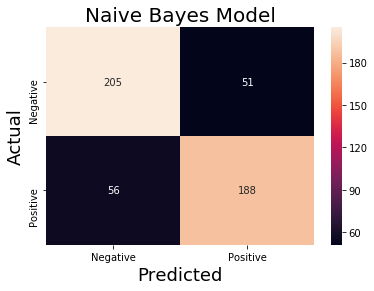

In [13]:
from helper_code import mlplots as ml

#fig, ax = plt.subplots(figsize=(13, 10))
# Call confusion matrix plotting routine
ml.confusion(y_test, y_pred, ['Negative', 'Positive'], 'Naive Bayes Model')

---
Next we display top words in predicting positive reviews. Note that since there are only two classes, either 0 or 1. There's only one list of coefficient for positive class. Because the model only need to classify positive reviews and the rest are negative reviews. If you want to find out top words for predicting negative reviews, you may reverse the label, map _neg_ to 1 and _pos_ to 0 and repeat following code.

We print out top 20 words for predicting positive movie reviews. There are _good_, _great_, _best_ and _love_ which make sense, but there are also many words like _film_, _movie_, _story_, and _really_ etc that don't make much sense. We can try add words like _film_ and _movie_ to stop words since those words are likely to appear in both positive and negative reviews. Or we can try another algorithm to see if we get better result.

In [14]:
all_words = np.array(tf_cv.get_feature_names())

top_word_index = np.argsort(nb.coef_[0])[-20:]
tn_lst = [word for word in all_words[top_word_index]]
tn_lst.reverse()

print(f'\nTop 20 Words of Positive Reviews:')
print(tn_lst)


Top 20 Words of Positive Reviews:
['film', 'movie', 'like', 'story', 'life', 'good', 'just', 'time', 'character', 'characters', 'films', 'great', 'best', 'does', 'way', 'love', 'really', 'people', 'man', 'little']


---
We now try `LogisticRegression` with `C` set to `1000`. This model gives better accuracy and a much better list of top words for predicting positive reviews.

---

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000)

lr = lr.fit(train_dtm_tf, y_train)
predicted = lr.predict(test_dtm_tf)

scr = 100.0 * lr.score(test_dtm_tf, y_test)
print(f'LR (TF-IDF with Stop Words) prediction accuracy = {scr:5.1f}%')

LR (TF-IDF with Stop Words) prediction accuracy =  82.2%


In [16]:
top_word_index = np.argsort(lr.coef_[0])[-20:]
tn_lst = [word for word in all_words[top_word_index]]
tn_lst.reverse()

print(f'\nTop 20 Words of Positive Reviews:')
print(tn_lst)


Top 20 Words of Positive Reviews:
['great', 'fun', 'life', 'hilarious', 'memorable', 'overall', 'quite', 'different', 'good', 'terrific', 'especially', 'trek', 'works', 'seen', 'performances', 'perfect', 'perfectly', 'comic', 'town', 'gives']


---
Next we reverse the label value, train the model again and get the top words for predicting negative reviews. Most words in the list make a lot of sense.

---

In [17]:
#reverse label value so that negative reviews have label 1
y_train_reverse = [0 if y==1 else 1 for y in y_train]
lr = lr.fit(train_dtm_tf, y_train_reverse)

top_word_index = np.argsort(lr.coef_[0])[-20:]
tn_lst = [word for word in all_words[top_word_index]]
tn_lst.reverse()

print(f'\nTop 20 words of Negative Reviews:')
print(tn_lst)


Top 20 words of Negative Reviews:
['bad', 'worst', 'plot', 'supposed', 'unfortunately', 'harry', 'boring', 'script', 'stupid', 'reason', 'poor', 'awful', 'waste', 'cheap', 'attempt', 'jakob', 'dull', 'lame', 'looks', 'better']


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous code cells, we classified movie reviews with default English stop words. Try add common words in movie reviews like _movie_ and _film_ to stop words. What impact this change has on each model?

-----

[[Back to TOC]](#Table-of-Contents)

## Stemming

In previous lesson, we introduced the concept of stemming. In the next code cell, we demonstrate how to apply stemming in text classification. We will use `PorterStemmer` in the `nltk` module for stemming.

We first define a function `tokenize`. The function has one argument `text` which is the text to be tokenized. The function uses `nltk.word_tokenize` function to tokenize `text` then apply `PorterStemmer` to stem the tokens. We then  set `tokenizer` argument in `CounterVectorizer` or `TfidfVectorizer` with this custom `tokenize` function and use the new vectorizer to create bag of words.

The following code takes longer to finish due to stemming, but it does give a better classification accuracy.

-----
[ws]: https://en.wikipedia.org/wiki/Stemming

In [18]:
import string
import nltk
from nltk.stem.porter import PorterStemmer

# Define function to tokenize text and apply stemmer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]

    stemmer = PorterStemmer()
    stems = map(stemmer.stem, tokens)
    return stems

# use custom tokenize when creating vectorizer
tf_cv = TfidfVectorizer()#tokenizer=tokenize)
train_dtm_tf = tf_cv.fit_transform(mvr_train)
test_dtm_tf = tf_cv.transform(mvr_test)

lr = LogisticRegression(C=1000)

lr = lr.fit(train_dtm_tf, y_train)
predicted = lr.predict(test_dtm_tf)

scr = 100.0 * lr.score(test_dtm_tf, y_test)
print(f'LR (TF-IDF with Stemming) prediction accuracy = {scr:5.1f}%')


LR (TF-IDF with Stemming) prediction accuracy =  84.2%


## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia articles on [n-grams][wng], [Stemming][wst], and [Lemmatization][wl]
1. Google [n-gram viewer][gnv]
1. Alternative [n-gram viewer][anv]
1. Blog on Sentiment Analysis with NLTK, [Part III][bsa3] and [Part IV][bsa4]
1. An online [Stemming Demo][std] using NLTK
1. A [treatise on Snowball][tsb] discussing, in depth, the process of stemming.

-----

[wst]: https://en.wikipedia.org/wiki/Stemming
[wl]: https://en.wikipedia.org/wiki/Lemmatisation
[wtc]: https://en.wikipedia.org/wiki/Document_clustering

[tsb]: http://snowball.tartarus.org/texts/introduction.html
[std]: http://text-processing.com/demo/stem/

[wng]: https://en.wikipedia.org/wiki/N-gram

[gnv]: https://books.google.com/ngrams
[anv]: http://xkcd.culturomics.org

[bsa3]: http://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/
[bsa4]: http://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/

[msdr]: http://research.microsoft.com/pubs/150728/FnT_dimensionReduction.pdf
[lle]: http://science.sciencemag.org/content/290/5500/2323.abstract
[ica]: http://www.cs.rutgers.edu/~mlittman/topics/dimred02/kolenda99independent.pdf1. 

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode